$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\E}{\mathbb{E}}
$

# Generative Adversarial Networks (GAN)


In 2014, Ian [Goodfellow, et al.](https://arxiv.org/abs/1406.2661) first devised the interesting structure of neural networks, which is called Generative Adversarial Networks (GAN). Here, you have two agents (modeld as neural networks) compete each other, one continues to produce fake data (*generator*) and the other keeps to check if it is generated or real one (*discriminator*). Thus, the generator needs to be able to fool the discriminator by producing good quality data that looks like real one. The discriminator as well needs to be a very good judgement module that can clearly identify fake ones. 

Let us take a look at Fig. 1 below. From random noise input, the generator produces fake image. When fake images are mixed with real images in training set, the distriminator is expected to judgy fake images correctly. 

<figure>
  <!--img src="pic_trulli.jpg" alt="Trulli" style="width:100%"-->
  <img src="https://cdn-images-1.medium.com/max/1400/0*2Smzp-1MDx2TTwU6.png" width=800 />
  <center>
  <figcaption> <font size=4>Fig.1 - Generative Adversarial Networks</font> <br/>
  (<font size="2">https://sthalles.github.io/intro-to-gans/</font>) </figcaption>
  </center>
</figure>




## Neural Network Formulation

Now, let the generator $G_{\wv_g}$ is a neural network that takes an noize input $\zv \sim p_\zv(\zv)$ to generate fake data: 

$$
  fake = G_{\wv_g}(\zv).
$$

Let the discriminator $D_{\wv_d}$ is another neural network that takes an image (data) input $\xv$, which is either fake ($\sim p_g$) or real ($\sim p_{data}$). Then the fake/real decision can be made by:

$$ 
  decision = D_{\wv_d}(\xv).
$$

When $D_{\wv_d}$ produces a probability value (from logistic sigmoid function), we train $D$ to maximize the probability to assign the correct label to both training data and fake samples from $G$, 
$$
  \log D_{\wv_d}(\xv).
$$

Simultaneously, we train $G$ to minimize the cases $D$ correctly classifies:
$$
  \log \Big(1 -  D_{\wv_d}\big(G_{\wv_g}(\zv)\big)\Big).
$$

This can be summarized in a mini-max problem as in

$$
  \min_G \max_D V(D, G) = \E_{\xv \sim p_{data}(\xv)}\Big[ \log D_{wv_d}(\xv) \Big] + \E_{\zv \sim p_\zv(\zv)}\Big[ \log \Big(1 -  D_{\wv_d}\big(G_{\wv_g}(\zv)\big)\Big) \Big].
$$


In [165]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

%matplotlib inline

## Generator

Generator takes a random vector $\zv$ as an input and produce a long vector (width $\times$ height $\times$ channels), which can be reshaped as an image. The network has 3 hidden layers with 256, 512, and 1024 hidden units respectively. 

In [166]:
def generator(input_dim, output_dim, alpha=0.2, momentum=0.8):
    """
    the generator network

    Paremeters
    ============
    intput_dim: the length of input random vector z
    output_dim: output dimension of the network, a tuple of (width, height, channel)
    alpha: scalar for lrelu activation function
    momentum: Boolean for controlling the batch normalization statistics
    
    @return model's output
    """
    w, h, c = output_dim

    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization(momentum=momentum))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization(momentum=momentum))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=alpha))
    model.add(BatchNormalization(momentum=momentum))
    model.add(Dense(w * h * c, activation='tanh'))
    model.add(Reshape(output_dim))

    return model
    

## Discriminator

Here we create a discriminator with a image as in input and judges if it is fake or real by using 2 hidden layers and one sigmoid output. 

In [167]:
def discriminator(alpha=0.2, dim=(28, 28, 1)):
    """
    the discriminator network
    
    Paremeters
    ============
    alpha: scalar for lrelu activation function
    dim: a tuple of (width, height, channels)
    
    @return: A tuple of (sigmoid probabilities, logits)
    """
    w, h, c = dim
    model = Sequential()
    model.add(Flatten(input_shape=dim))
    model.add(Dense((w * h * c), input_shape=dim))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dense(np.int64((w * h * c)/2)))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

## Optimization

We use Adam optimizer to train the GAN. Losses are defined as binary crossentropy. 

In [168]:
learning_rate = 0.0002
beta = 0.5
decay = 8e-8

AdamOptim = Adam(lr=learning_rate, beta_1=beta, decay=decay)

In [192]:
def build(optimizer, dim):
    """
    build

    Parameters
    ============
    optimizer     common optimizer for training networks
    dim           dimensionality, a tuple of (input_dim = |z|, output_dim=(width, height, channels))

    @return       Generator, Disciriminator, and GAN (stacked G & D)
    """
    
    input_dim, output_dim = dim

    # build generator
    G = generator(input_dim, output_dim, alpha=0.2, momentum=0.8) #generator()
    G.compile(loss='binary_crossentropy', optimizer=optimizer)

    # build discriminator
    D = discriminator()
    D.trainable = True
    D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # build GAN
    #D.trainable = False
    #GAN = Sequential()
    #GAN.add(G)
    #GAN.add(D)
    frozen_D = Model(inputs=D.inputs, outputs=D.outputs, name="Discriminator-frozen")
    frozen_D.trainable = False
    GAN = Sequential(name="GAN")
    GAN.add(G)
    GAN.add(frozen_D)
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    GAN.summary()
    
    return G, D, GAN, (input_dim, output_dim)

## Training GAN



In [193]:
def display_images(dataset, figsize=(6,6)):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        # denormalize 
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img.reshape(28,28), cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)        


In [194]:
def train(Model, X_train, epochs=20000, batch = 32, plot_interval = 1000):
    """
        train GAN
        
        Parameters
        ====================
        Model          a tuple of (Generator, Disicrimininator, GAN) 
        X_train .      train data
        dim            a tuple of input and output dimension (|z|, width, height, channels)
        epochs .       the number of epochs for training
        batch .        the batch size
        save_interval  interval to save generated images
    """

    G, D, GAN, (n_z, (w, h, c)) = Model
    
    dloss = []
    gloss = []
    for cnt in range(epochs):
        
        ####################################
        # train discriminator
        random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
        legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape(np.int64(batch/2), w, h, c)

        gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
        syntetic_images = G.predict(gen_noise)

        x_combined_batch = np.concatenate((legit_images, syntetic_images))
        y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

        d_loss = D.train_on_batch(x_combined_batch, y_combined_batch) # single gradient update
        dloss.append(d_loss[0])

        ####################################
        # train generator
        noise = np.random.normal(0, 1, (batch, 100))
        y_mislabled = np.ones((batch, 1))

        g_loss = GAN.train_on_batch(noise, y_mislabled)
        gloss.append(g_loss)

        #print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

        if cnt % plot_interval == 0:
            print("epoch: %d [d_loss: %f, g_loss: %f]" % (cnt, d_loss[0], g_loss))
            noise = np.random.normal(0, 1, (36, 100))
            generated = G.predict(noise)
            display_images(generated)
            plt.show()

    # generator and discriminator loss 
    plt.figure(figsize=(10,6))
    plt.plot(dloss, label="Discriminator $L_D$", color="orange")
    plt.plot(gloss, label="Generator $L_G$", color="green")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    


# MNIST Data

In [188]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [195]:
(X_train, _), (_, _) = mnist.load_data()

# rescale... 
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


In [196]:
X_train.shape

(60000, 28, 28, 1)

In [197]:
model = build(AdamOptim, (100, (28, 28, 1)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 784)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 392)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________
____

epoch: 0 [d_loss: 0.660674, g_loss: 0.656616]


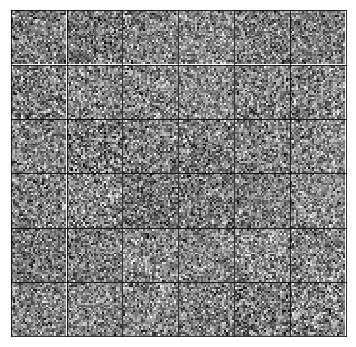

epoch: 1000 [d_loss: 0.633487, g_loss: 0.757293]


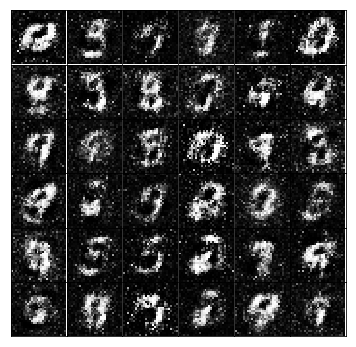

epoch: 2000 [d_loss: 0.756567, g_loss: 0.639010]


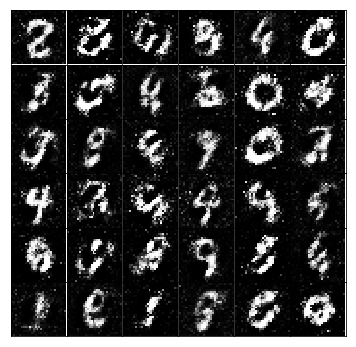

epoch: 3000 [d_loss: 0.544447, g_loss: 0.969904]


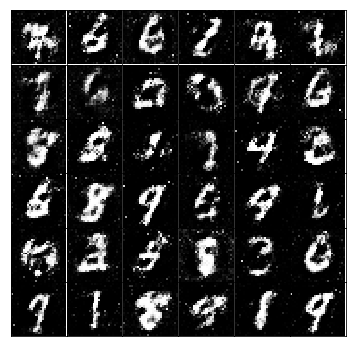

epoch: 4000 [d_loss: 0.511392, g_loss: 0.917261]


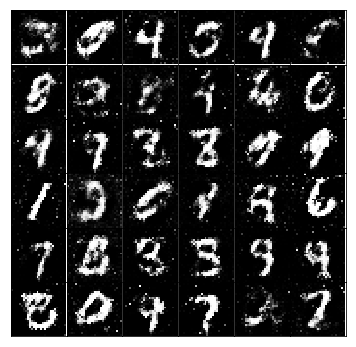

epoch: 5000 [d_loss: 0.631898, g_loss: 0.991038]


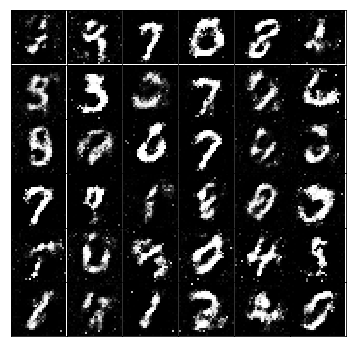

epoch: 6000 [d_loss: 0.630369, g_loss: 0.906989]


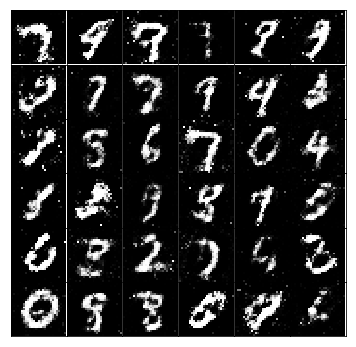

epoch: 7000 [d_loss: 0.630812, g_loss: 1.323315]


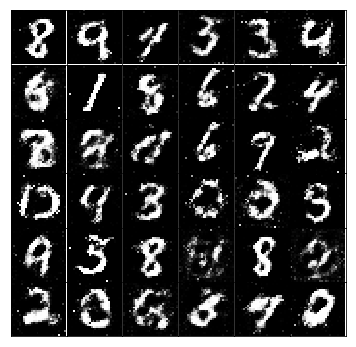

epoch: 8000 [d_loss: 0.597695, g_loss: 0.806616]


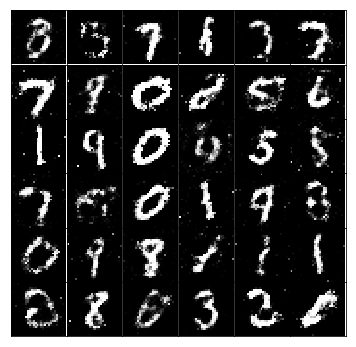

epoch: 9000 [d_loss: 0.664256, g_loss: 0.812607]


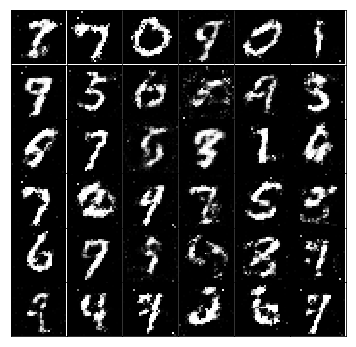

epoch: 10000 [d_loss: 0.724732, g_loss: 0.905172]


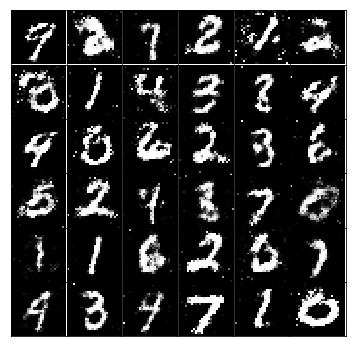

epoch: 11000 [d_loss: 0.652725, g_loss: 0.872171]


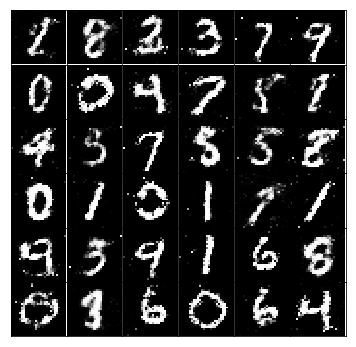

epoch: 12000 [d_loss: 0.596669, g_loss: 0.699453]


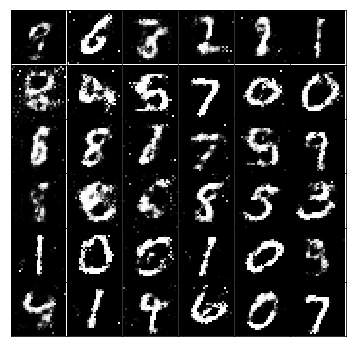

epoch: 13000 [d_loss: 0.674017, g_loss: 0.821659]


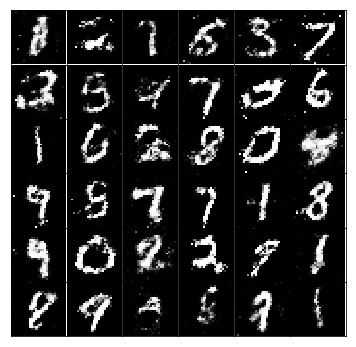

epoch: 14000 [d_loss: 0.706179, g_loss: 0.709896]


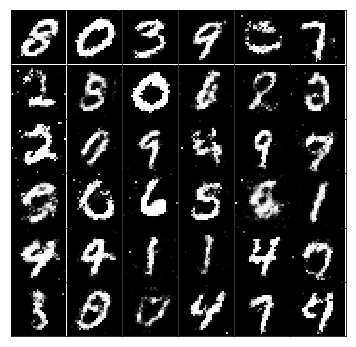

epoch: 15000 [d_loss: 0.640056, g_loss: 0.773420]


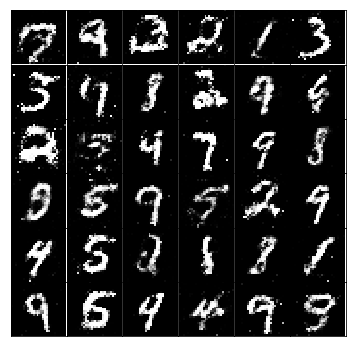

epoch: 16000 [d_loss: 0.590580, g_loss: 0.899827]


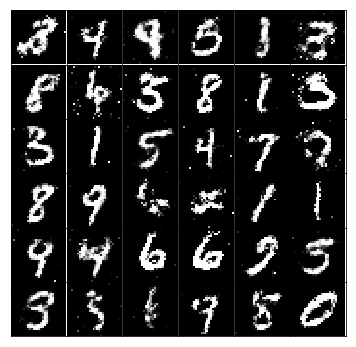

epoch: 17000 [d_loss: 0.660762, g_loss: 0.859339]


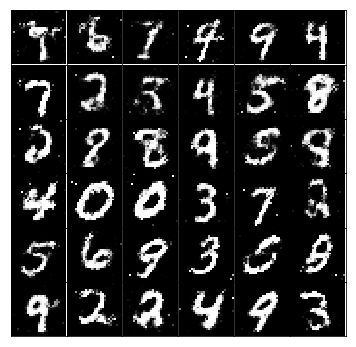

epoch: 18000 [d_loss: 0.650703, g_loss: 0.870779]


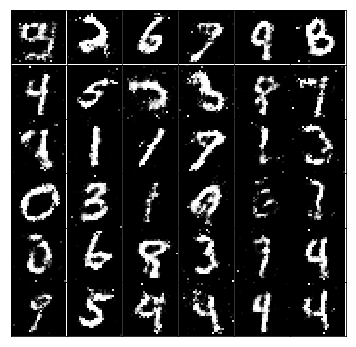

epoch: 19000 [d_loss: 0.660598, g_loss: 0.816144]


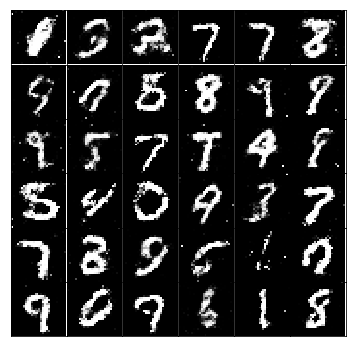

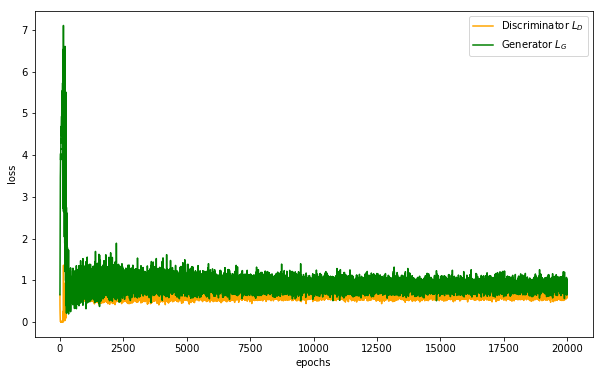

In [198]:
train(model, X_train)